# Time Series Modeling: Romanian Electricity

## Overview
- This project attempts to build an ARIMA model on hourly electricity consumption and production rates for Romania from 2019 to mid-March 2023.

Analysis will attempt manual and auto-ARIMA derivations of 

- **P**: lag order (AutoRegressive Component - AR)
- **D**: degree of differencing (Integragtion Component - I)
- **Q**: order of the moving average (Moving Average Component - MA)
---

[Data Source](https://www.kaggle.com/datasets/stefancomanita/hourly-electricity-consumption-and-production)

Table Data
All values in MegaWatts (MW)

| Fields | Interpretation | Example |
| --- | --- | --- |
| DateTime | Hourly Timestamp | 1/1/2019  7:00:00 AM |
| Consumption | Total Romanian Energy Consumption (MW) | 5524 |
| Production | Total Romanian Energy Production (MW) | 5547 |
| Nuclear | Total Romanian Nuclear Energy Consumption (MW) | 1392 |
| Wind | Total Romanian Wind Energy Production (MW) | 93 |
| Hydroelectric | Total Romanian Hydroelectric Energy Production (MW) | 1187 |
| Oil and Gas | Total Romanian Oil and Gas Energy Production (MW) | 1446 |
| Coal | Total Romanian Coal Energy Production (MW) | 1394 |
| Solar | Total Romanian Solar Energy Production (MW) | 0 |
| Biomass | Total Romanian Biomass Energy Production (MW) | 34 |

## Overview / Executive Summary

### Recommendations 
- Observe seasonality and periodicity on other variables, such as Solar Production.
 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import os
import matplotlib.pyplot as plt

#Load the CSV file as dataframe, df
os.chdir(r"C:\Users\Public\Documents")
df = pd.read_csv("electricityConsumptionAndProductioction.csv", index_col='DateTime', parse_dates=True)

# Confirm loading CSV
# Look at the dataframe structure

print(df.info())
print(df.describe())

df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36772 entries, 2019-01-01 00:00:00 to 2023-03-12 23:00:00
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Consumption    36772 non-null  int64
 1   Production     36772 non-null  int64
 2   Nuclear        36772 non-null  int64
 3   Wind           36772 non-null  int64
 4   Hydroelectric  36772 non-null  int64
 5   Oil and Gas    36772 non-null  int64
 6   Coal           36772 non-null  int64
 7   Solar          36772 non-null  int64
 8   Biomass        36772 non-null  int64
dtypes: int64(9)
memory usage: 2.8 MB
None
        Consumption    Production       Nuclear          Wind  Hydroelectric  \
count  36772.000000  36772.000000  36772.000000  36772.000000   36772.000000   
mean    6707.924889   6543.770478   1293.468590    785.700723    1801.603149   
std     1034.961146   1005.486125    237.348752    681.508967     678.981785   
min     4081.000000   3315.00000

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
DateTime,,,,,,,,,
2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


## Data Cleaning & Transformation
- I trust that outliers are real due to national level monitoring systems

- Check for duplicates and missing values
     - Time series data cannot have missing values
     - Initial glimpse at data above suggests no missing values (36,772 values across all fields)


In [2]:
# Check for any missing values
df.isnull().values.any()

False

In [3]:
# No missing records

# Check for any Duplicates
df.duplicated().values.any()

True

In [4]:
# Identify duplicates
df[df.duplicated()]

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
DateTime,,,,,,,,,
2019-03-02 22:00:00,7538,7277,1391,288,1762,1506,2271,0,59
2019-03-02 23:00:00,7538,7277,1391,288,1762,1506,2271,0,59
2019-03-03 00:00:00,7538,7277,1391,288,1762,1506,2271,0,59
2019-06-07 16:00:00,7039,7034,659,151,3968,434,1147,647,29
2019-06-07 17:00:00,7039,7034,659,151,3968,434,1147,647,29
...,...,...,...,...,...,...,...,...,...
2023-01-16 04:00:00,5604,6878,1402,1304,1569,1624,913,0,66
2023-01-16 05:00:00,5604,6878,1402,1304,1569,1624,913,0,66
2023-01-19 19:00:00,7598,9148,1408,2709,2344,1439,1178,0,70


In [5]:
# 4 duplicate records
# Drop duplicates, keep one record
df.drop_duplicates(inplace = True)

# Check for any Duplicates
df.duplicated().values.any()

False

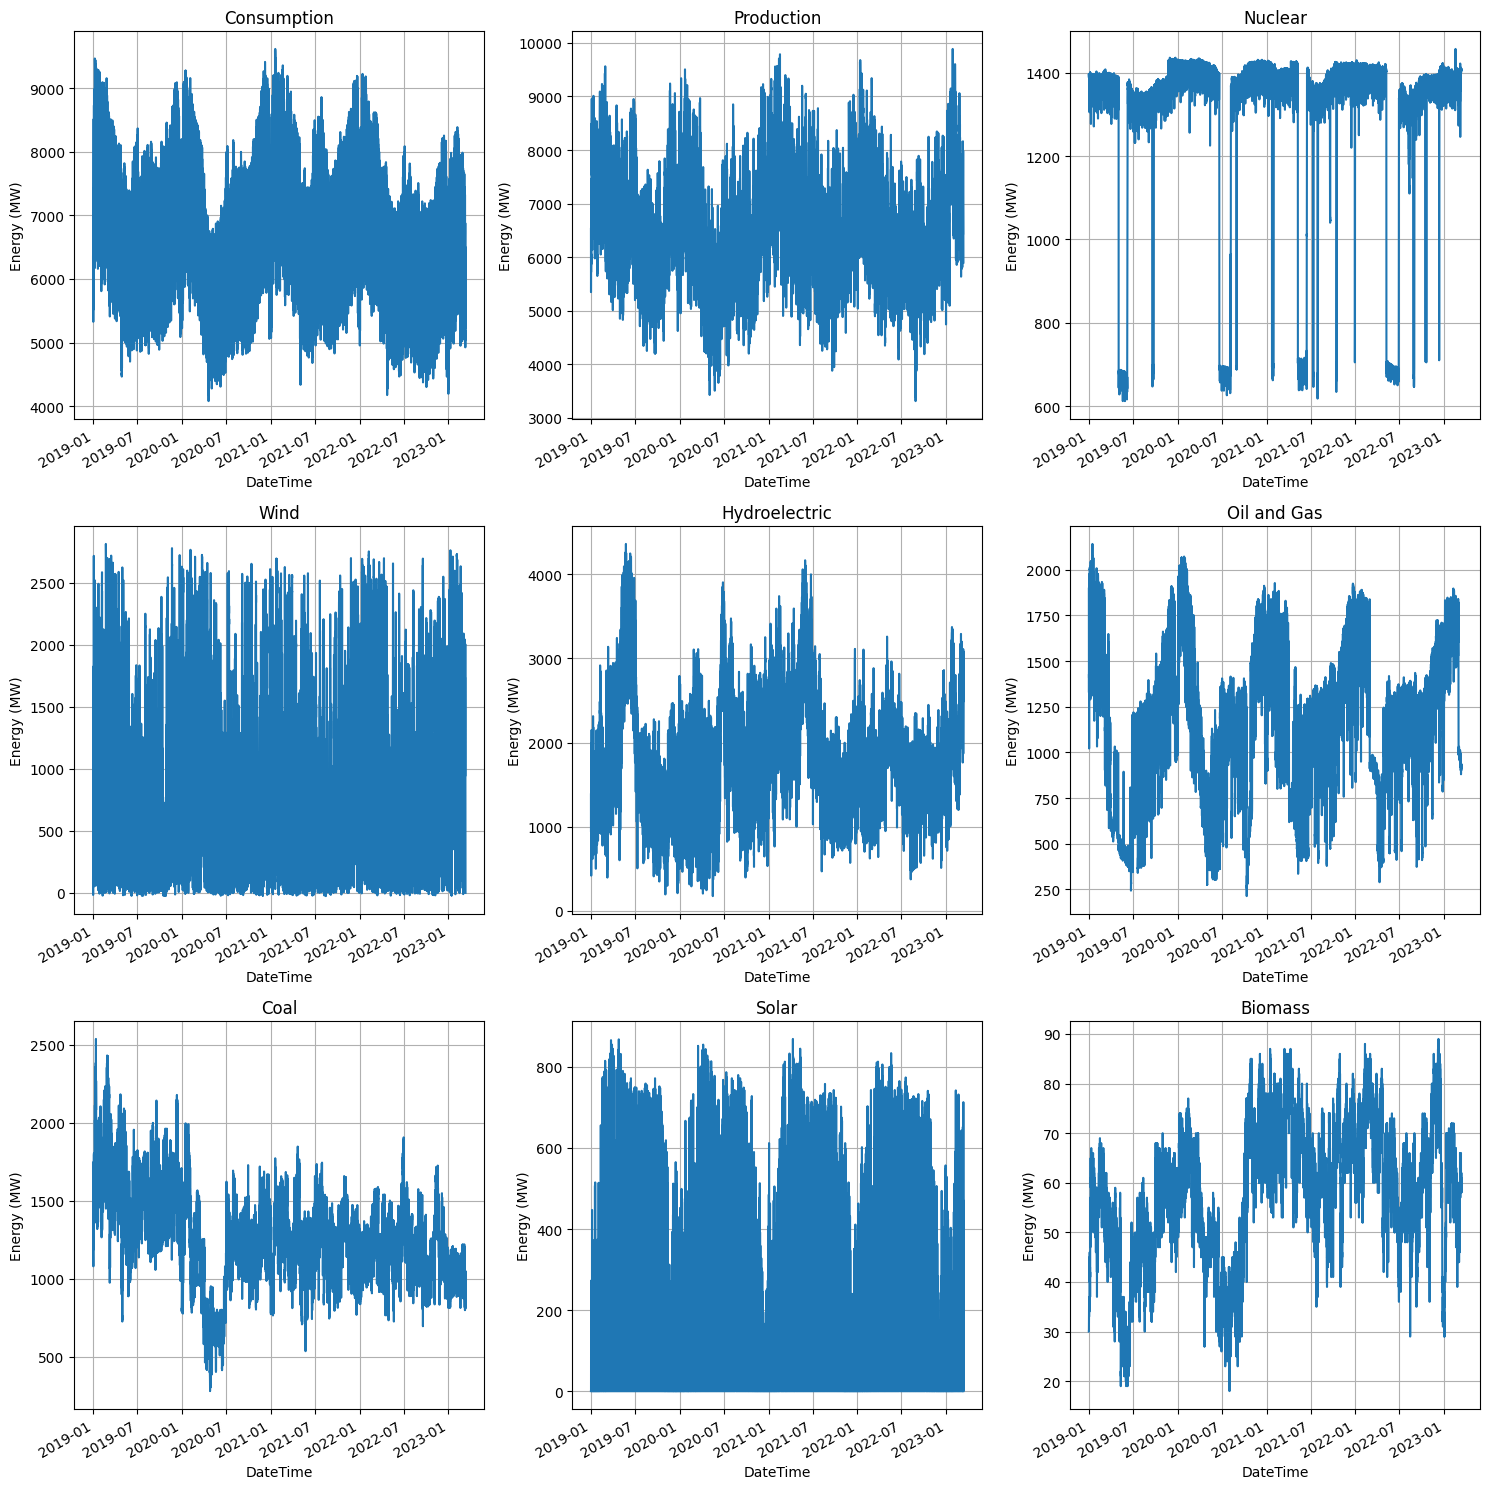

In [6]:
# Plot Romainian Energy 
fig,axs = plt.subplots(3,3, figsize = (15,15))

columns_to_plot = ['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']

# Iterate over the columns and plot each one on a separate subplot
for i, column in enumerate(columns_to_plot):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    df[column].plot(grid=True, ax=ax)
    ax.set_title(column)
axs[0,0].set_ylabel('Energy (MW)')
axs[0,1].set_ylabel('Energy (MW)')
axs[0,2].set_ylabel('Energy (MW)')
axs[1,0].set_ylabel('Energy (MW)')
axs[1,1].set_ylabel('Energy (MW)')
axs[1,2].set_ylabel('Energy (MW)')
axs[2,0].set_ylabel('Energy (MW)')
axs[2,1].set_ylabel('Energy (MW)')
axs[2,2].set_ylabel('Energy (MW)')

fig.tight_layout()


### Data Cleaning Complete
- Duplicates Removed
- DateTime column is converted to Index with date parsing

## Model Development
### Time Series Assumptions
- Stationarity
  - Normally distributed
  - Mean and variance are constant over time
  - No trends
  - Constant variance and autocorrelation
- Radnomly distributed Error Term
- No Outliers
- Residuals are **not** autocorrelated

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, pacf, acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [8]:
# Check stationarity of energy consumption
results = adfuller(df['Consumption'])

print('Test Statistics: ', results[0])
print('p-value: ', results[1])
print('# of lags: ', results[2])
print('Crticial Values: ', results[4])

# p-value is <0.05 on non differenced data
# I = 0

Test Statistics:  -13.947571492854333
p-value:  4.766499535452963e-26
# of lags:  52
Crticial Values:  {'1%': -3.4305303077713565, '5%': -2.861619691667109, '10%': -2.566812417354478}


In [9]:
# Check stationarity
if results[1]<= 0.05:
    print('Reject null hypothesis, the time series is stationary')
else:
    print("Fail to reject null hypothesis, the time series in not stationary")

Reject null hypothesis, the time series is stationary


In [10]:
# Spit data for holdout testing

print(round(0.7*df.shape[0]) + round(0.3*df.shape[0]) == df.shape[0])
train = df.iloc[:-round(0.3*df.shape[0])]    # take out the last 30% of the data
test = df.iloc[-round(0.3*df.shape[0]):] # include the last 30% of the data 
print(train.shape, test.shape)

True
(25426, 9) (10897, 9)


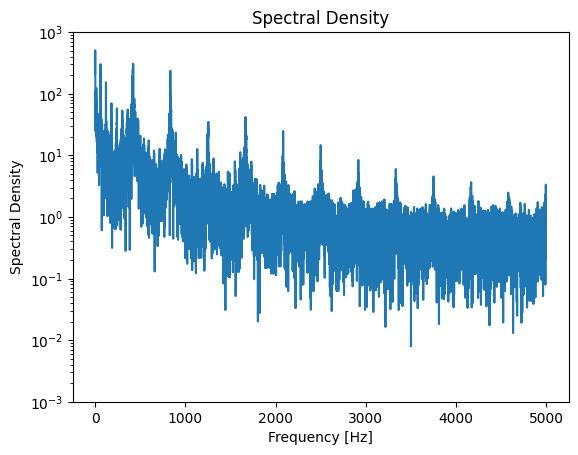

In [11]:
# Spectral Density

from scipy import signal
f, Pxx_spec = signal.periodogram(df['Consumption'], 10e3, 'flattop', scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.ylim([1e-3, 1e3])
plt.title('Spectral Density')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Spectral Density')
plt.show()

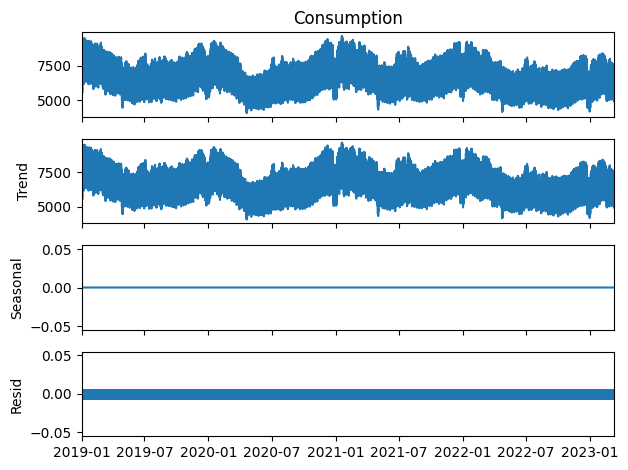

In [12]:
# Periodogram
# Additive Decomposition: https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Consumption'], model='additive', period=1)
result.plot()
plt.show()

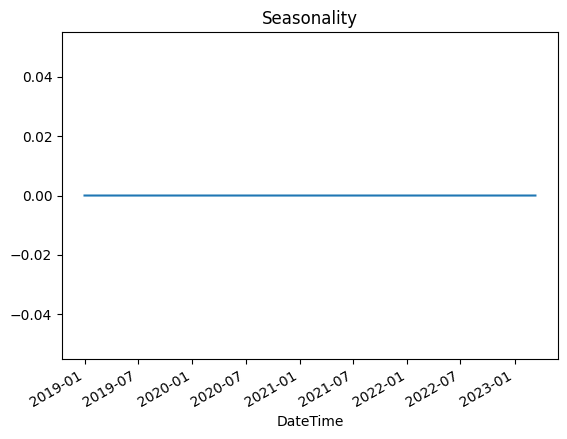

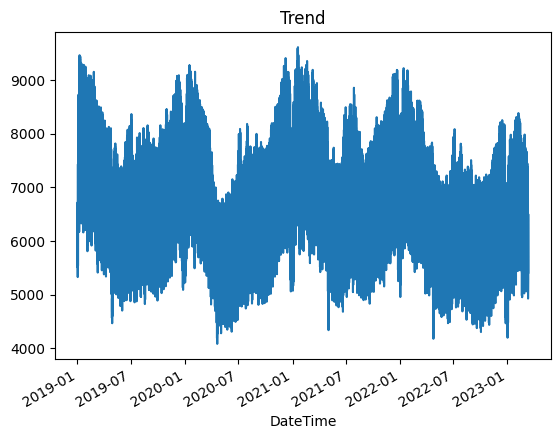

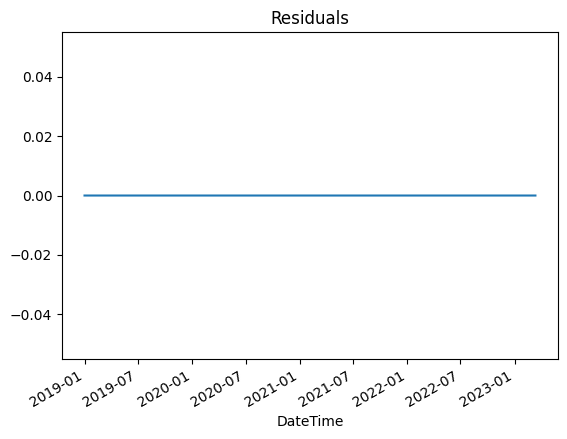

In [13]:
result.seasonal.plot()
plt.title('Seasonality')
plt.show()
result.trend.plot()
plt.title('Trend')
plt.show()
result.resid.plot()
plt.title('Residuals')
plt.show()

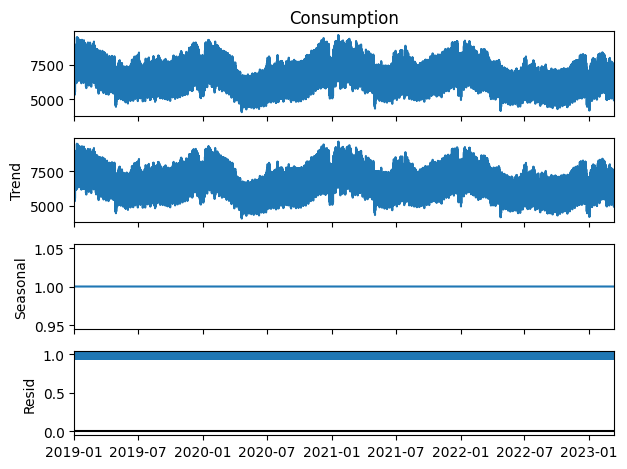

In [14]:
# Periodogram
# Multiplicative Decomposition: https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

from pandas import Series
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Consumption'], model='multiplicative', period=1)
result.plot()
plt.show()

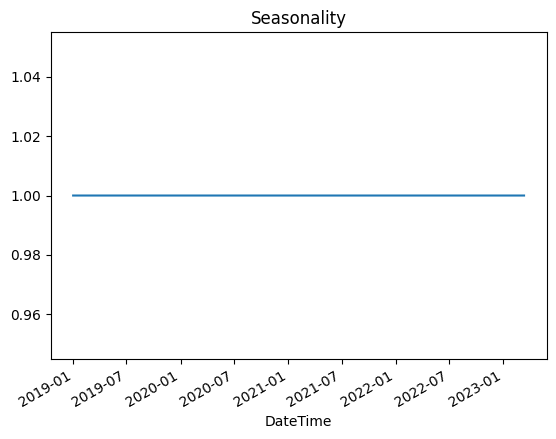

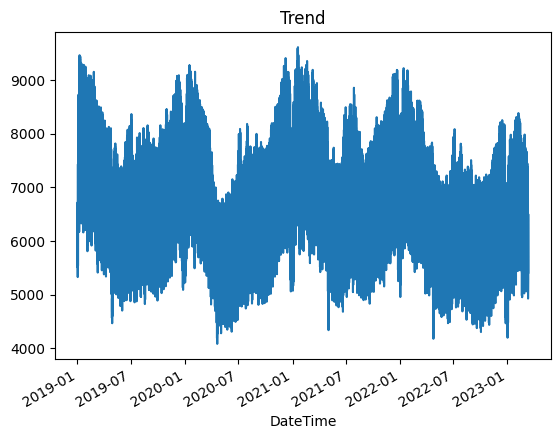

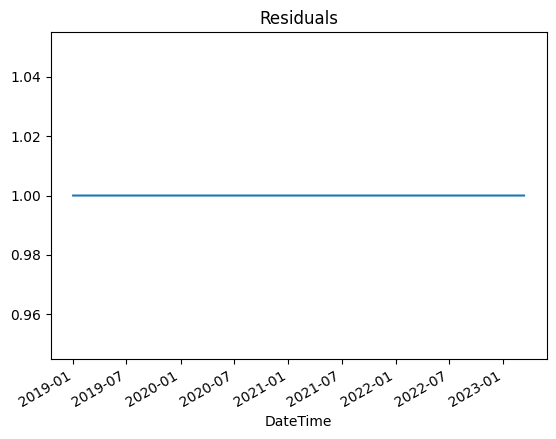

In [15]:
result.seasonal.plot()
plt.title('Seasonality')
plt.show()
result.trend.plot()
plt.title('Trend')
plt.show()
result.resid.plot()
plt.title('Residuals')
plt.show()

## Auto-ARIMA

In [16]:
# pip install pmdarima
# Run the ARIMA model on training data
from pmdarima.arima import auto_arima
model_auto = auto_arima(train['Production'], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=340861.138, Time=9.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=349682.863, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=342713.005, Time=0.75 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=344287.248, Time=2.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=349680.863, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=342628.339, Time=2.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=342682.041, Time=5.42 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=340481.619, Time=18.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=340907.669, Time=13.00 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=340911.601, Time=21.43 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=340854.391, Time=23.70 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=340830.149, Time=21.81 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=340875.852, Time=23.23 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=29.40 sec
 ARIM

In [17]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                25426
Model:               SARIMAX(3, 1, 2)   Log Likelihood             -170233.062
Date:                Sun, 12 May 2024   AIC                         340478.124
Time:                        16:40:27   BIC                         340526.985
Sample:                             0   HQIC                        340493.926
                              - 25426                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.2824      0.006    354.735      0.000       2.270       2.295
ar.L2         -1.6846      0.012   -139.285      0.000      -1.708      -1.661
ar.L3          0.3599      0.006     57.985      0.000       0.348       0.372
ma.L1         -1.8981      0.003   -620.429      0.000      -1.904      -1.892
ma.L2          0.9502      0.003    318.522      0.000       0.944       0.956
sigma2      4.035e+04    258.303    156.208      0.000    3.98e+04    4.09e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.52   Jarque-Bera (JB):              8333.65
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.44
Prob(H) (two-sided):                  0.31   Kurtosis:                         5.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Prediction

In [18]:
# index the dates
index_future_dates = pd.date_range(start = '2021-12-13 09:00:00', end = '2024-09-13 00:00:00', freq = 'H')
print(index_future_dates)
# Make predictions
pred = model_auto.predict(n_periods= 24112)

pred.index= index_future_dates

print(pred)

DatetimeIndex(['2021-12-13 09:00:00', '2021-12-13 10:00:00',
               '2021-12-13 11:00:00', '2021-12-13 12:00:00',
               '2021-12-13 13:00:00', '2021-12-13 14:00:00',
               '2021-12-13 15:00:00', '2021-12-13 16:00:00',
               '2021-12-13 17:00:00', '2021-12-13 18:00:00',
               ...
               '2024-09-12 15:00:00', '2024-09-12 16:00:00',
               '2024-09-12 17:00:00', '2024-09-12 18:00:00',
               '2024-09-12 19:00:00', '2024-09-12 20:00:00',
               '2024-09-12 21:00:00', '2024-09-12 22:00:00',
               '2024-09-12 23:00:00', '2024-09-13 00:00:00'],
              dtype='datetime64[ns]', length=24112, freq='H')


C:\Users\raven\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\raven\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


2021-12-13 09:00:00    7034.229246
2021-12-13 10:00:00    7142.541626
2021-12-13 11:00:00    7234.621866
2021-12-13 12:00:00    7304.152948
2021-12-13 13:00:00    7346.713377
                          ...     
2024-09-12 20:00:00    6916.328929
2024-09-12 21:00:00    6916.328929
2024-09-12 22:00:00    6916.328929
2024-09-12 23:00:00    6916.328929
2024-09-13 00:00:00    6916.328929
Freq: H, Length: 24112, dtype: float64


### Auto-ARIMA Prediction Model

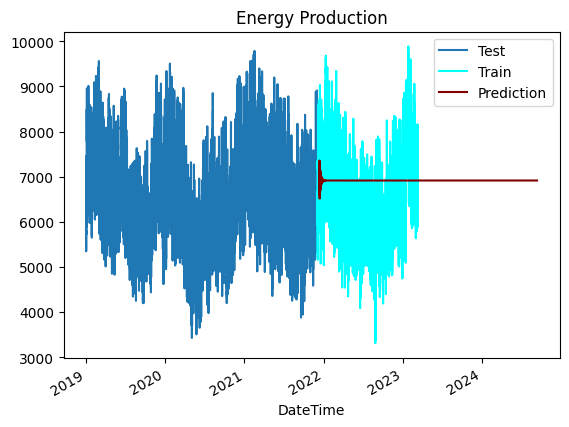

In [19]:
train['Production'].plot(legend=True, label = 'Test')
test['Production'].plot(legend=True, label = 'Train', color = 'aqua')
pred.plot(legend=True, label = 'Prediction', color = 'maroon')
plt.title('Energy Production')
plt.show()

## Manual ARIMA

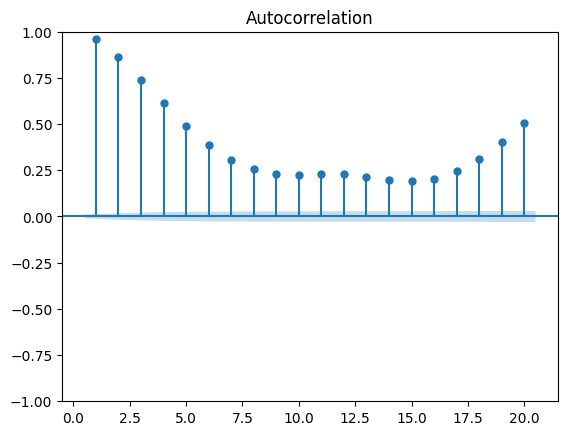

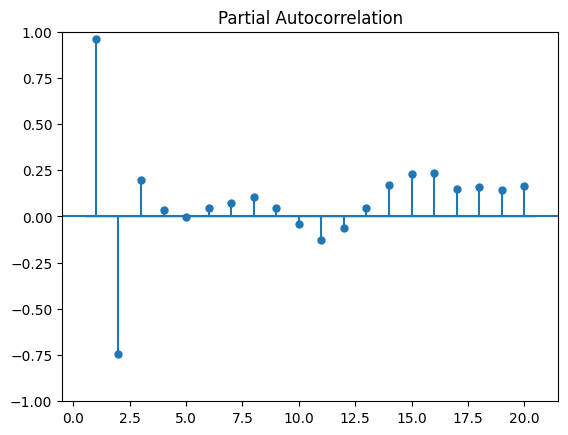

In [20]:
plot_acf(df['Consumption'], lags=20, zero = False)
#Q = 0
plot_pacf(df['Consumption'], lags=20, zero = False)
plt.show()
# P = 0

In [21]:
# Run an ARIMA model
model_manual = ARIMA(train['Consumption'], order = (0,0,0))
model_manual = model_manual.fit()
model_manual.summary()


C:\Users\raven\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\raven\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\raven\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                25426
Model:                          ARIMA   Log Likelihood             -328767.518
Date:                Sun, 12 May 2024   AIC                         657539.036
Time:                        16:40:36   BIC                         657555.323
Sample:                             0   HQIC                        657544.304
                              - 25426                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6793.0080   1.65e+05      0.041      0.967   -3.16e+05    3.29e+05
sigma2       2.71e+10    3.4e+08     79.725      0.000    2.64e+10    2.78e+10
===================================================================================
Ljung-Box (L1) (Q):               23393.95   Jarque-Bera (JB):               565.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.14
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
# index the dates
# Make predictions

pred_manual = model_manual.predict(n_periods= 25426)
pred_manual.index = pd.date_range(start = '2021-12-13 09:00:00', end = '2024-11-06 18:00:00', freq = 'H')

#pred_manual.index= index_future_dates

print(pred_manual)


2021-12-13 09:00:00    6793.007984
2021-12-13 10:00:00    6793.007984
2021-12-13 11:00:00    6793.007984
2021-12-13 12:00:00    6793.007984
2021-12-13 13:00:00    6793.007984
                          ...     
2024-11-06 14:00:00    6793.007984
2024-11-06 15:00:00    6793.007984
2024-11-06 16:00:00    6793.007984
2024-11-06 17:00:00    6793.007984
2024-11-06 18:00:00    6793.007984
Freq: H, Name: predicted_mean, Length: 25426, dtype: float64


### Manual-ARIMA Prediction Model

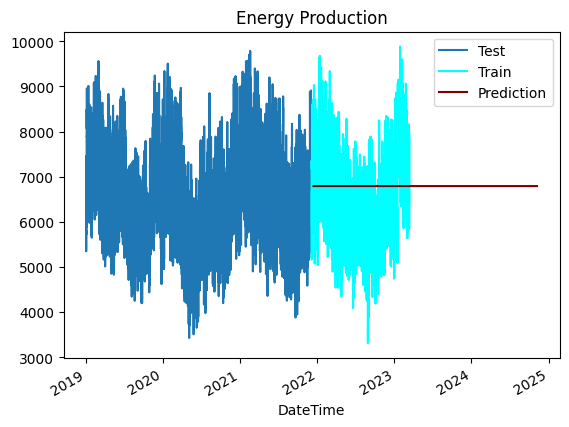

In [23]:
train['Production'].plot(legend=True, label = 'Test')
test['Production'].plot(legend=True, label = 'Train', color = 'aqua')
pred_manual.plot(legend=True, label = 'Prediction', color = 'maroon')
plt.title('Energy Production')
plt.show()

## Compare Model Accuracy
### Accuracy Metric: AIC 
- minimized AIC is more accurate

In [24]:
auto_aic = model_auto.aic()
manual_aic = model_manual.aic
print(f'Auto-ARIMA AIC: {round(auto_aic)}\n\nManual-ARIMA AIC: {round(manual_aic)}')

Auto-ARIMA AIC: 340478

Manual-ARIMA AIC: 657539


## Results
The Auto-ARIMA model is more accurate than the manually derived ARIMA model.

No overt seasonality was observed in energy production.

Both models predict an average after intial cycles.